# Mod 3 Final Project

## Student Info

- Name: Steve Newman
- Cohort: 10/7/19 Part Time
- Instructor: James Irving PhD


For this project I will employ hypothesis testing using statistical testing techniques in order to assist the company Norhtwind improve it's marketing and sales initiatives.  

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-mod-3-project-online-ds-ft-100719/master/Northwind_ERD_updated.png">

# Questions to Answer

H1 Does discount amount have a statistically significant effect on order quantity? If so, at what level(s) of discount?

H2 Do order quantities of countries differ when discounted?

H3 Does purchase month have an effect on quantity per order?

H4 Does region have an effect on quantity per order?

### Import Libraries


In [222]:
 !pip install -U fsds_100719
 from fsds_100719.imports import *

import pandas as pd
from functions import Cohen_d, find_outliers_IQR,find_outliers_Z
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import functions as fn

## Uncomment the line below to see the source code for the imported functions
# fs.ihelp(Cohen_d,False),fs.ihelp(find_outliers_IQR,False), fs.ihelp(find_outliers_Z,False)

Requirement already up-to-date: fsds_100719 in /Users/srn/anaconda3/envs/learn-env/lib/python3.6/site-packages (0.7.16)


In [223]:
import sqlite3
connect = sqlite3.connect('Northwind_small.sqlite')
cur = connect.cursor()

In [224]:
cur.execute("""SELECT name FROM sqlite_master WHERE type='table';""")
df_tables = pd.DataFrame(cur.fetchall(), columns=['Table'])
df_tables

,Table
0,Employee
1,Category
2,Customer
3,Shipper
4,Supplier
5,Order
6,Product
7,OrderDetail
8,CustomerCustomerDemo
9,CustomerDemographic


# HYPOTHESIS 1

> ***Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?***

- $H_0$: A discount does not effect the quantity of a product in an order.
- $H_1$: A discount does effect the quantity of a product in an order.

In [225]:
cur.execute("""SELECT * FROM OrderDetail """)
names = [description[0] for description in cur.description]
df_OrderDetail = pd.DataFrame(cur.fetchall(), columns = names)
df_OrderDetail

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.00,12,0.00
1,10248/42,10248,42,9.80,10,0.00
2,10248/72,10248,72,34.80,5,0.00
3,10249/14,10249,14,18.60,9,0.00
4,10249/51,10249,51,42.40,40,0.00
...,...,...,...,...,...,...
2150,11077/64,11077,64,33.25,2,0.03
2151,11077/66,11077,66,17.00,1,0.00
2152,11077/73,11077,73,15.00,2,0.01
2153,11077/75,11077,75,7.75,4,0.00


## Determine if data is numerical or categorical

In [226]:
# Data is numerical.
# Find quantity of discounted orders by discount amount.

df_OrderDetail['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

## Determine how many groups to compare to establish which test to use.

### Two groups are being compared; use the 2 Sample T-Test.

In [227]:
# Assign 'Discounted' and 'Full Price' to 'groups' column.
# Assign '0' to 'Full Price' and '1' to 'Discounted' in the 'group_num' column.

df_OrderDetail['groups'] = df_OrderDetail['Discount'] >0 
df_OrderDetail['groups'] = df_OrderDetail['groups'].map({True:'Discounted', False:'Full Price'})
df_OrderDetail['group_num'] = df_OrderDetail['groups'].map({'Discounted':1,"Full Price": 0})

df_OrderDetail

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,groups,group_num
0,10248/11,10248,11,14.00,12,0.00,Full Price,0
1,10248/42,10248,42,9.80,10,0.00,Full Price,0
2,10248/72,10248,72,34.80,5,0.00,Full Price,0
3,10249/14,10249,14,18.60,9,0.00,Full Price,0
4,10249/51,10249,51,42.40,40,0.00,Full Price,0
...,...,...,...,...,...,...,...,...
2150,11077/64,11077,64,33.25,2,0.03,Discounted,1
2151,11077/66,11077,66,17.00,1,0.00,Full Price,0
2152,11077/73,11077,73,15.00,2,0.01,Discounted,1
2153,11077/75,11077,75,7.75,4,0.00,Full Price,0


### Check data to see if it meets test assumptions.

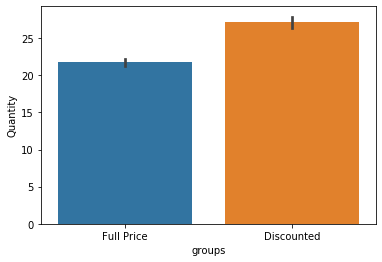

In [228]:
# View barplot to see if the categories are statistically different and compare standard error of the mean.
# Discounted products sold in larger quantities.

sns.barplot(data=df_OrderDetail, x='groups', y='Quantity', ci=68 )

In [229]:
# Create 'grps' dictionary to seperate 'quantity' into 'Full Price' and 'Discounted' categories.

grps = {}
for grp_name in df_OrderDetail['groups'].unique():
    grps[grp_name] = df_OrderDetail.groupby('groups').get_group(grp_name)['Quantity']
grps

{'Full Price': 0       12
 1       10
 2        5
 3        9
 4       40
         ..
 2147     2
 2148     2
 2151     1
 2153     4
 2154     2
 Name: Quantity, Length: 1317, dtype: int64, 'Discounted': 6        35
 7        15
 8         6
 9        15
 11       40
 12       25
 17       15
 18       21
 29       50
 30       65
 31        6
 34       16
 36       15
 37       21
 40       12
 43       60
 45       60
 46       36
 48       25
 51       12
 53       70
 54       15
 57       60
 58       20
 65       24
 66       15
 68       60
 69       33
 72       12
 73        6
 82       15
 95       15
 97       20
 98        5
 99       45
 100      40
 101      36
 104      40
 106      15
 107      10
 108       3
 115      20
 116      24
 117       2
 135      40
 136      30
 147      40
 148      30
 149      15
 153      25
 154      25
 155      30
 177      40
 178      30
 179      25
 196      21
 197      70
 199      40
 200      80
 209      25
 210      50
 21

### Check for outliers.

[Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Total Ordered by Discounted and Full Price Group')]

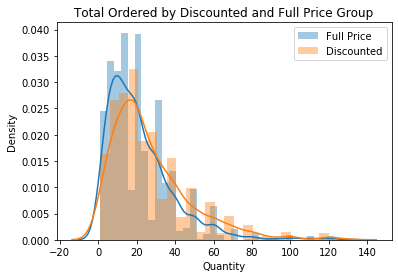

In [230]:
# Show Distribution Plot of both groups to determine if normailty assumption is met.

for grp_name,grp_data in grps.items():
    sns.distplot(grp_data,label=grp_name)
    
    
ax= plt.gca()
ax.legend()
ax.set(title='Total Ordered by Discounted and Full Price Group', ylabel='Density')

In [231]:
orig_grps = grps.copy()

In [232]:
# Identify how many outliers found in each group using Z-Scores and IQR.

for grp_name, grp_data in grps.items():
    idx_outs =find_outliers_Z(grp_data)
    print(f"Found {idx_outs.sum()} outliers in {grp_name} using Z-scores")
    grps[grp_name] = grp_data [~idx_outs]
    idx_outs =find_outliers_IQR(grp_data)

    print(f"Found {idx_outs.sum()} outliers in {grp_name} using IQR")
    print('\n')

Found 20 outliers in Full Price using Z-scores
Found 34 outliers in Full Price using IQR


Found 15 outliers in Discounted using Z-scores
Found 29 outliers in Discounted using IQR




In [233]:
# Remove outliers.

grp_data [~idx_outs]

6       35
7       15
8        6
9       15
11      40
12      25
17      15
18      21
29      50
30      65
31       6
34      16
36      15
37      21
40      12
43      60
45      60
46      36
48      25
51      12
53      70
54      15
57      60
58      20
65      24
66      15
68      60
69      33
72      12
73       6
82      15
95      15
97      20
98       5
99      45
100     40
101     36
104     40
106     15
107     10
108      3
115     20
116     24
117      2
135     40
136     30
147     40
148     30
149     15
153     25
154     25
155     30
177     40
178     30
179     25
196     21
197     70
199     40
209     25
210     50
211     35
212     30
216     10
217      8
218     20
219     12
220     50
221     25
223     40
224     10
225     16
227     10
228     40
231      7
232     25
233      6
234     48
235     18
244     70
246     20
247     12
248     40
250      9
251     24
252     56
253     40
254     40
256      4
259     70
263     36
266     50

[Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Total Quantity for Full Price vs Discounted Products')]

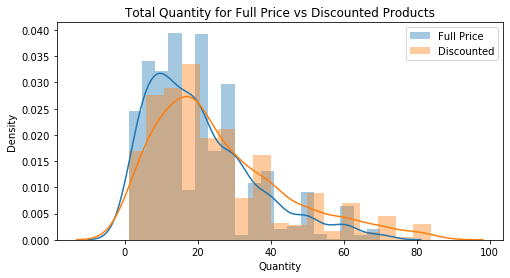

In [234]:
# Check for normality after removing outliers.

fig,ax=plt.subplots(figsize=(8,4))
for grp_name,grp_data in grps.items():
    sns.distplot(grp_data,label=grp_name, ax=ax)
    
    
ax.legend()
ax.set(title='Total Quantity for Full Price vs Discounted Products', ylabel='Density')

### Confirm normality with scipy normal test.

In [235]:
for k,v in grps.items():
    stat,p = stats.normaltest(v)
    print(f"Group {k} Normaltest p-value = {round(p,4)}")
    sig = 'is NOT' if p<.05 else 'IS'
    print(f"\t-The data is {sig} normal.")

Group Full Price Normaltest p-value = 0.0
	-The data is is NOT normal.
Group Discounted Normaltest p-value = 0.0
	-The data is is NOT normal.


In [236]:
# Failed normality test; check sample sizes to see if large enough to bypass normality assumption.

In [237]:
# Each group is greater than 15; safe to ignore normality assumption.

len(grps['Full Price']), len(grps['Discounted'])

(1297, 823)

## Check for equal variance.

In [238]:
# Prepare data for levene test to check for equal variance.

data = []
for k,v in grps.items():
    data.append(v)
data[0]

0       12
1       10
2        5
3        9
4       40
        ..
2147     2
2148     2
2151     1
2153     4
2154     2
Name: Quantity, Length: 1297, dtype: int64

In [239]:
# Reject the Levene test null hypothesis that all input samples are from populations with equal variances.

stat, p = stats.levene(*data)
print(f"Levene' Test for Equal Variance p-value={round(p,4)}")
sig = 'do NOT' if p<.05 else 'DO'

print(f"\t- The groups {sig} have equal variance.")

Levene' Test for Equal Variance p-value=0.0
	- The groups do NOT have equal variance.


In [240]:
# Test using alternative Welch's T-Test for equal variance.
# P value is less than 0.05; reject null hypothesis that the groups have identical average values.

stat,p = stats.ttest_ind(grps['Full Price'], grps['Discounted'], equal_var=False)
print(f"Welch's t-test p value={round(p,4)}")

Welch's t-test p value=0.0


In [241]:
# Check for effect size.
# Effect size is small, indicating the difference in means is trivial.
Cohen_d(grps['Full Price'],grps['Discounted'])

-0.32001140965727837

In [242]:
# Run Tukey test to see which groups are different.
# Tukey result: 0.0 vs 0.05, 0.15, 0.20, and 0.25 are different.

model = pairwise_tukeyhsd(df_OrderDetail['Quantity'],df_OrderDetail['Discount'])
model.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0.0,0.01,-19.7153,0.9,-80.3306,40.9001,False
0.0,0.02,-19.7153,0.9,-62.593,23.1625,False
0.0,0.03,-20.0486,0.725,-55.0714,14.9742,False
0.0,0.04,-20.7153,0.9,-81.3306,39.9001,False
0.0,0.05,6.2955,0.0011,1.5381,11.053,True
0.0,0.06,-19.7153,0.9,-80.3306,40.9001,False
0.0,0.1,3.5217,0.4269,-1.3783,8.4217,False
0.0,0.15,6.6669,0.0014,1.551,11.7828,True
0.0,0.2,5.3096,0.0303,0.2508,10.3684,True
0.0,0.25,6.525,0.0023,1.3647,11.6852,True


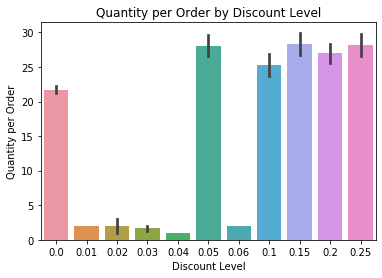

In [243]:
ax = sns.barplot(data=df_OrderDetail,x='Discount',y='Quantity',ci=68)
ax.set(title= 'Quantity per Order by Discount Level', xlabel = 'Discount Level', ylabel='Quantity per Order');

## Conclusion

The null hypothesis is rejected. A discount does effect the quantity of a product in an order. A 5%, 15%, 20%, and 25% discount all increase order quantity from not offering any discount. Interstingly, a 5% discount appears to match or in some cases increase quantity sold compared to all other discounts. 

It is recommended to offer a 5% discount and not offer the other discounts in order to save revenue.

# HYPOTHESIS 2

> ***Do order quantities of different countries differ when discounted?***

- $H_0$: Order quantities of different countries are the same when discounted.
- $H_1$: Order quantities of different countries are not the same when discounted.

In [244]:
cur.execute("""SELECT * FROM 'Order'""")
names = [description[0] for description in cur.description]
df_order = pd.DataFrame(cur.fetchall(), columns = names)
df_order.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [245]:
cur.execute("""SELECT * FROM OrderDetail """)
names = [description[0] for description in cur.description]
df_OrderDetail = pd.DataFrame(cur.fetchall(), columns = names)
df_OrderDetail

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.00,12,0.00
1,10248/42,10248,42,9.80,10,0.00
2,10248/72,10248,72,34.80,5,0.00
3,10249/14,10249,14,18.60,9,0.00
4,10249/51,10249,51,42.40,40,0.00
...,...,...,...,...,...,...
2150,11077/64,11077,64,33.25,2,0.03
2151,11077/66,11077,66,17.00,1,0.00
2152,11077/73,11077,73,15.00,2,0.01
2153,11077/75,11077,75,7.75,4,0.00


In [246]:
# Assign 'Discounted' and 'Full Price' to 'groups' column.
# Assign '0' to 'Full Price' and '1' to 'Discounted' in the 'group_num' column.

df_OrderDetail['groups'] = df_OrderDetail['Discount'] >0 
df_OrderDetail['groups'] = df_OrderDetail['groups'].map({True:'Discounted', False:'Full Price'})
df_OrderDetail['group_num'] = df_OrderDetail['groups'].map({'Discounted':1,"Full Price": 0})

df_OrderDetail

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,groups,group_num
0,10248/11,10248,11,14.00,12,0.00,Full Price,0
1,10248/42,10248,42,9.80,10,0.00,Full Price,0
2,10248/72,10248,72,34.80,5,0.00,Full Price,0
3,10249/14,10249,14,18.60,9,0.00,Full Price,0
4,10249/51,10249,51,42.40,40,0.00,Full Price,0
...,...,...,...,...,...,...,...,...
2150,11077/64,11077,64,33.25,2,0.03,Discounted,1
2151,11077/66,11077,66,17.00,1,0.00,Full Price,0
2152,11077/73,11077,73,15.00,2,0.01,Discounted,1
2153,11077/75,11077,75,7.75,4,0.00,Full Price,0


In [247]:
# Prepare df_order to merge with df_OrderDetail
df_order.rename({'Id':'OrderId'}, axis=1, inplace=True)
df_order.head()

,OrderId,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [248]:
df_merge = df_OrderDetail.merge(df_order, on='OrderId', copy=True)
df_merge.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,groups,group_num,CustomerId,EmployeeId,...,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248/11,10248,11,14.0,12,0.0,Full Price,0,VINET,5,...,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10248/42,10248,42,9.8,10,0.0,Full Price,0,VINET,5,...,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
2,10248/72,10248,72,34.8,5,0.0,Full Price,0,VINET,5,...,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
3,10249/14,10249,14,18.6,9,0.0,Full Price,0,TOMSP,6,...,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
4,10249/51,10249,51,42.4,40,0.0,Full Price,0,TOMSP,6,...,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany


## Determine if data is numerical or categorical

In [249]:
# Data is numerical.
# Comparing the total quantity of orders by country.

In [250]:
# Create df_ctry for discounted quantities.

df_ctry = df_merge[df_merge['group_num'] == 1][['ShipCountry', 'Quantity']]
df_ctry.head()

,ShipCountry,Quantity
6,Brazil,35
7,Brazil,15
8,France,6
9,France,15
11,Belgium,40


## Determine how many groups to compare to establish which test to use.

### More than two groups are being compared; use a One-Way ANOVA .

### Check data to see if it meets test assumptions.

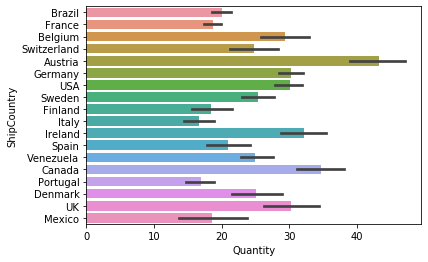

In [251]:
# View barplot to see if the categories are statistically different and compare standard error of the mean.
# Many countries bought discounted products in different quantities.

sns.barplot(data=df_ctry, x='Quantity', y='ShipCountry', ci=68,)

### Check for outliers.

In [252]:
# Create 'grps' dictionary to seperate 'countries' by 'quantity'.

grps = {}
for grp_name in df_ctry['ShipCountry'].unique():
    grps[grp_name] = df_ctry.groupby('ShipCountry').get_group(grp_name)['Quantity']
grps

{'Brazil': 6       35
 7       15
 104     40
 106     15
 115     20
 116     24
 117      2
 266     50
 268      6
 330     12
 331     40
 332     70
 333     42
 344      8
 345     16
 346     20
 421     30
 422     42
 423      5
 424      2
 442     18
 459     20
 460      2
 461      8
 462     20
 463      4
 465     15
 466     10
 636     24
 655     20
 689     10
 690      9
 691      6
 692     12
 784     35
 785      4
 786     36
 787      9
 892     50
 944     20
 945     20
 946     10
 988     18
 1027    25
 1028    60
 1042     4
 1044    21
 1054    15
 1058    25
 1062     2
 1083    20
 1084    24
 1085    40
 1159    20
 1160    30
 1377    15
 1392    20
 1409    30
 1410    15
 1411    42
 1420     3
 1421    20
 1429    15
 1430     6
 1452    24
 1453    15
 1454    15
 1476    12
 1531     8
 1532    20
 1547    30
 1548    15
 1582     5
 1583    10
 1584    10
 1585    42
 1628    42
 1650    30
 1702     3
 1712    20
 1728    30
 1729    40
 1756 

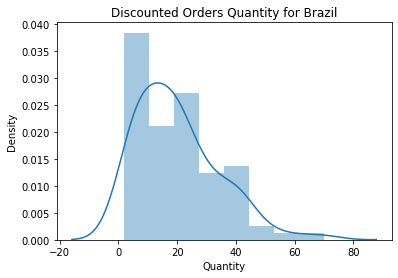

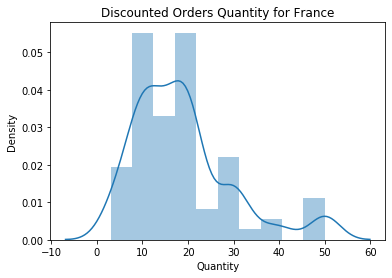

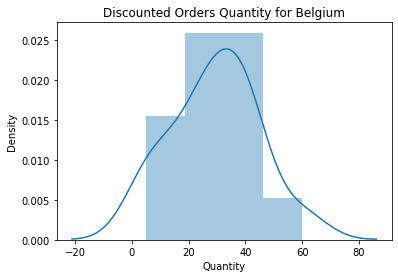

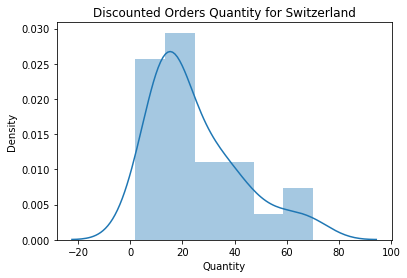

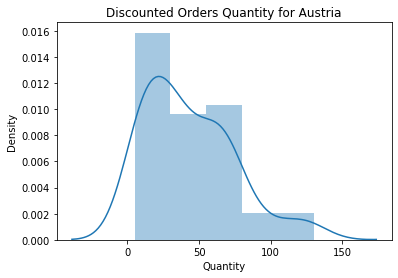

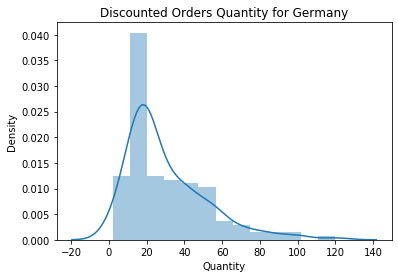

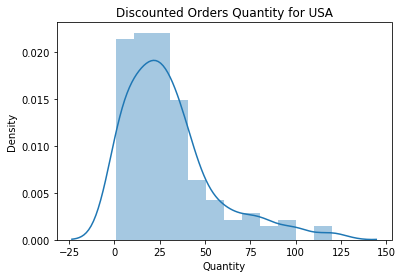

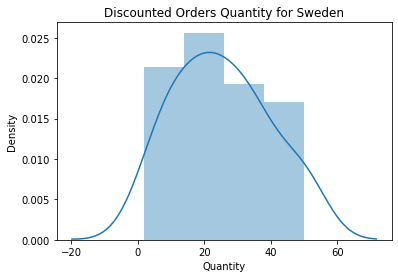

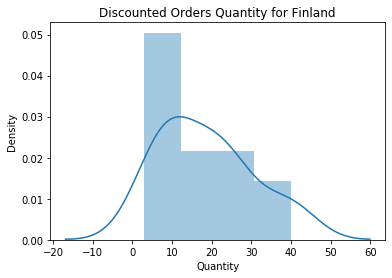

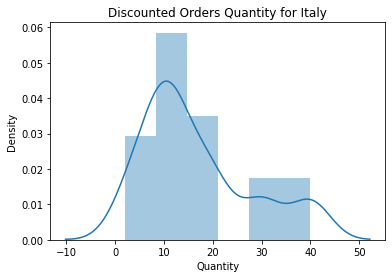

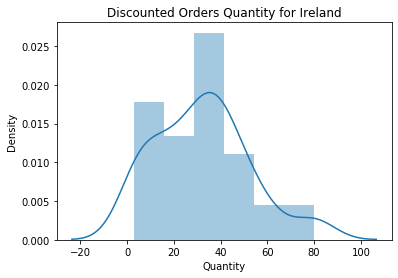

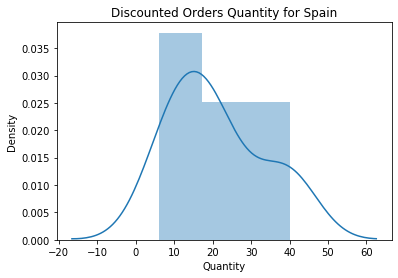

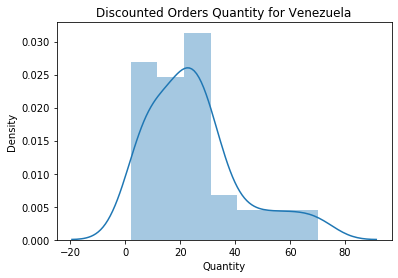

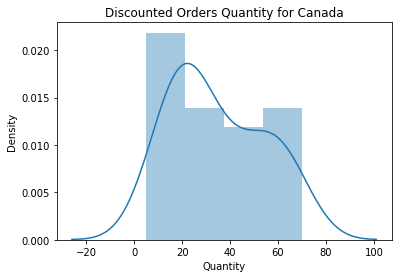

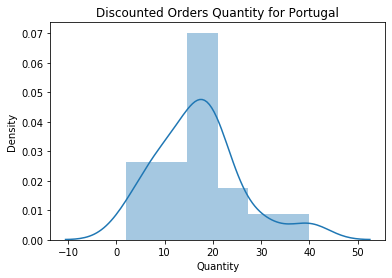

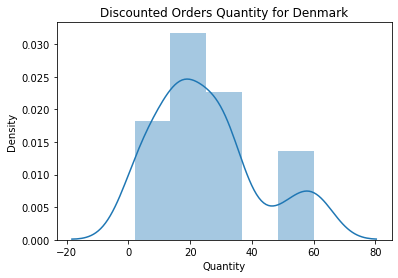

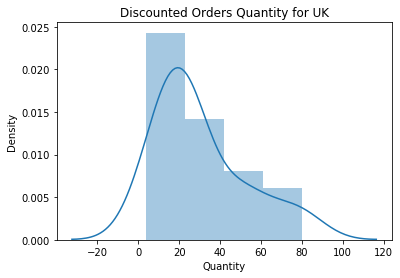

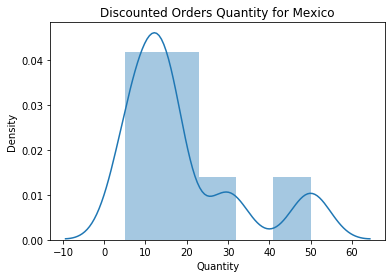

In [253]:
# Show distribution plot of 'discounted' group to determine if normality assumption is met.

for grp_name,grp_data in grps.items():
    fig,ax =plt.subplots()
    sns.distplot(grp_data,label=grp_name, ax=ax)
    ax.set(title=f'Discounted Orders Quantity for {grp_name}', ylabel='Density')

In [254]:
orig_grps = grps.copy()

In [255]:
# Identify how many outliers found in each group using Z-Scores.

for grp_name, grp_data in grps.items():
    idx_outs =find_outliers_Z(grp_data)
    print(f"Found {idx_outs.sum()} outliers in {grp_name} using Z-scores")
    grps[grp_name] = grp_data [~idx_outs]

Found 1 outliers in Brazil using Z-scores
Found 0 outliers in France using Z-scores
Found 0 outliers in Belgium using Z-scores
Found 0 outliers in Switzerland using Z-scores
Found 0 outliers in Austria using Z-scores
Found 3 outliers in Germany using Z-scores
Found 2 outliers in USA using Z-scores
Found 0 outliers in Sweden using Z-scores
Found 0 outliers in Finland using Z-scores
Found 0 outliers in Italy using Z-scores
Found 0 outliers in Ireland using Z-scores
Found 0 outliers in Spain using Z-scores
Found 0 outliers in Venezuela using Z-scores
Found 0 outliers in Canada using Z-scores
Found 0 outliers in Portugal using Z-scores
Found 0 outliers in Denmark using Z-scores
Found 0 outliers in UK using Z-scores
Found 0 outliers in Mexico using Z-scores


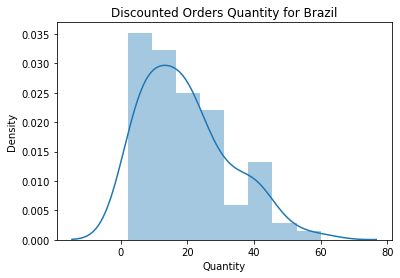

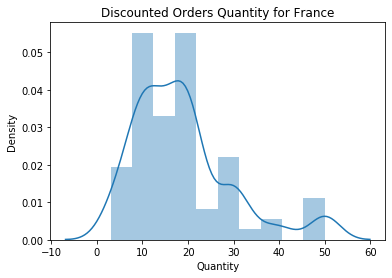

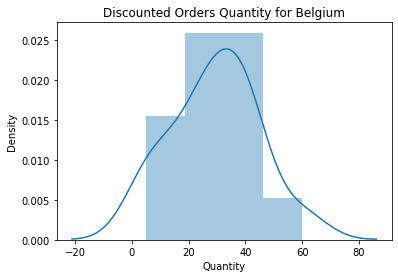

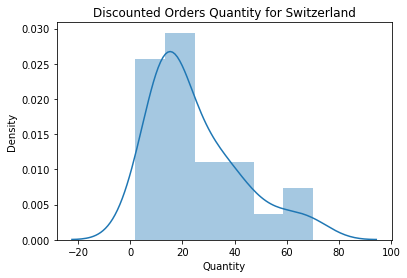

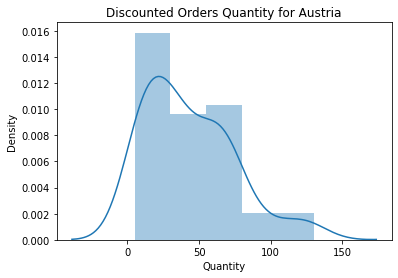

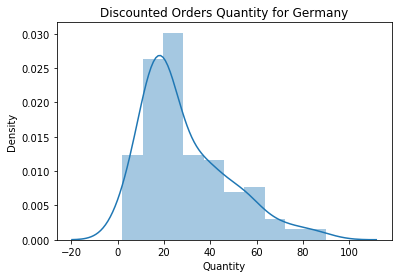

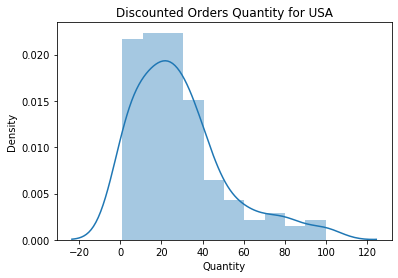

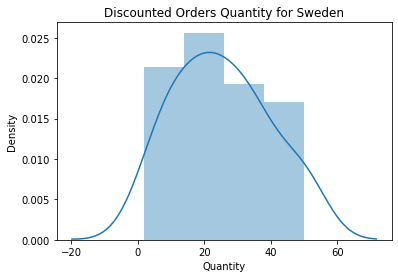

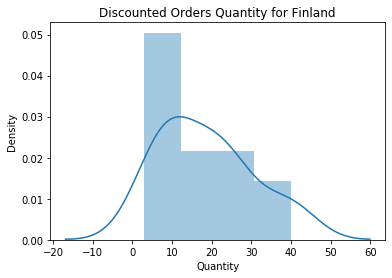

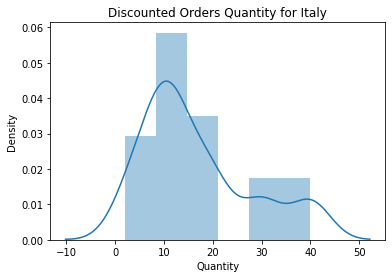

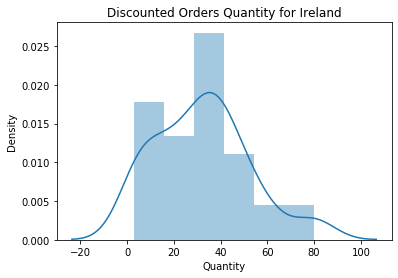

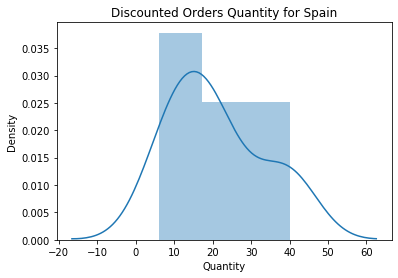

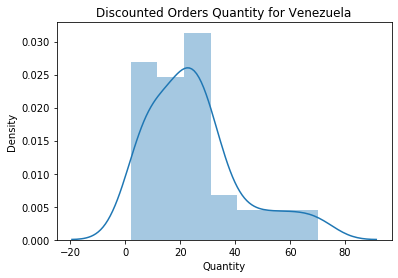

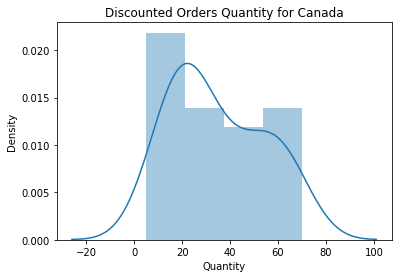

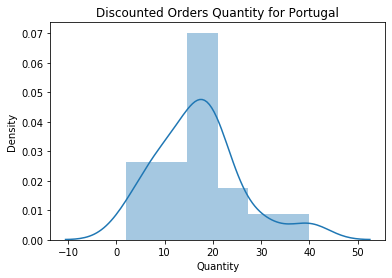

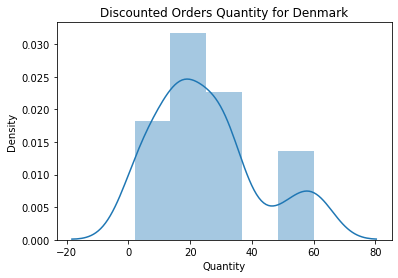

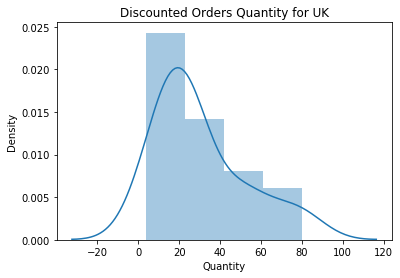

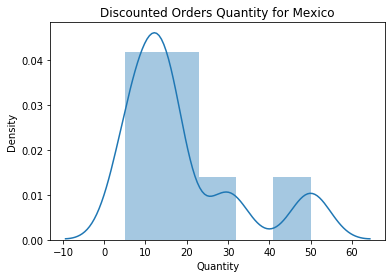

In [256]:
# Show Distribution Plot of Discounted group to determine if normailty assumption is met.

for grp_name,grp_data in grps.items():
    fig,ax =plt.subplots()
    sns.distplot(grp_data,label=grp_name, ax=ax)
    ax.set(title=f'Discounted Orders Quantity for {grp_name}', ylabel='Density')

### Confirm normality with scipy normal test.

In [257]:
for k,v in grps.items():
    stat,p = stats.normaltest(v)
    print(f"Group {k} Normaltest p-value = {round(p,4)}")
    sig = 'is NOT' if p<.05 else 'IS'
    print(f"\t-The data is {sig} normal.")
    print(f"Group {k} sample size = {len(v)}")
    size = 'CAN' if len(v)>20 else 'CAN NOT'
    print(f"\t-Normality assumption {size} be ignored.")
    print('\n')

Group Brazil Normaltest p-value = 0.0112
	-The data is is NOT normal.
Group Brazil sample size = 94
	-Normality assumption CAN be ignored.


Group France Normaltest p-value = 0.0001
	-The data is is NOT normal.
Group France sample size = 77
	-Normality assumption CAN be ignored.


Group Belgium Normaltest p-value = 0.9793
	-The data is IS normal.
Group Belgium sample size = 14
	-Normality assumption CAN NOT be ignored.


Group Switzerland Normaltest p-value = 0.0339
	-The data is is NOT normal.
Group Switzerland sample size = 24
	-Normality assumption CAN be ignored.


Group Austria Normaltest p-value = 0.0182
	-The data is is NOT normal.
Group Austria sample size = 58
	-Normality assumption CAN be ignored.


Group Germany Normaltest p-value = 0.0
	-The data is is NOT normal.
Group Germany sample size = 147
	-Normality assumption CAN be ignored.


Group USA Normaltest p-value = 0.0
	-The data is is NOT normal.
Group USA sample size = 140
	-Normality assumption CAN be ignored.


Group S

In [258]:
# Failed normality test and sample sizes are not large enough to bypass normality assumption.
# Due to failure to pass normaility test, proceed with Kruskal-Wallis test.

In [259]:
# Prepare data for hypothesis testing.

data = []
for k,v in grps.items():
    data.append(v)
data[0]

6       35
7       15
104     40
106     15
115     20
116     24
117      2
266     50
268      6
330     12
331     40
333     42
344      8
345     16
346     20
421     30
422     42
423      5
424      2
442     18
459     20
460      2
461      8
462     20
463      4
465     15
466     10
636     24
655     20
689     10
690      9
691      6
692     12
784     35
785      4
786     36
787      9
892     50
944     20
945     20
946     10
988     18
1027    25
1028    60
1042     4
1044    21
1054    15
1058    25
1062     2
1083    20
1084    24
1085    40
1159    20
1160    30
1377    15
1392    20
1409    30
1410    15
1411    42
1420     3
1421    20
1429    15
1430     6
1452    24
1453    15
1454    15
1476    12
1531     8
1532    20
1547    30
1548    15
1582     5
1583    10
1584    10
1585    42
1628    42
1650    30
1702     3
1712    20
1728    30
1729    40
1756    25
1757    12
1784     4
1785     8
1843    20
1846     6
2063    10
2064     4
2067    30
2068    10

In [260]:
# Kruskal-Wallis test result is p-value is less than .05.
# The null hypothesis that the population median of all of the groups are equal is rejected.

stats.kruskal(*data)

KruskalResult(statistic=73.94483142717863, pvalue=4.466630803214601e-09)

In [261]:
# Prepare data for Tukey function. Check to see which pairs of groups are different.

data = fn.prep_data_for_tukeys(grps)
data

,data,group
6,35.0,Brazil
7,15.0,Brazil
104,40.0,Brazil
106,15.0,Brazil
115,20.0,Brazil
116,24.0,Brazil
117,2.0,Brazil
266,50.0,Brazil
268,6.0,Brazil
330,12.0,Brazil


In [262]:
model = pairwise_tukeyhsd(data['data'],data['group'])
model.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Austria,Belgium,-13.8867,0.5329,-33.4055,5.6321,False
Austria,Brazil,-23.7256,0.001,-34.6704,-12.7808,True
Austria,Canada,-8.5595,0.8166,-23.1431,6.0241,False
Austria,Denmark,-18.1724,0.0285,-35.4993,-0.8456,True
Austria,Finland,-24.7057,0.001,-43.6932,-5.7183,True
Austria,France,-24.4971,0.001,-35.8936,-13.1006,True
Austria,Germany,-14.4377,0.001,-24.6018,-4.2736,True
Austria,Ireland,-11.0296,0.348,-25.0596,3.0005,False
Austria,Italy,-26.5057,0.001,-41.7771,-11.2343,True
Austria,Mexico,-24.6724,0.0511,-49.3941,0.0493,False


In [263]:
df = pd.DataFrame(data=model._results_table.data[1:], columns=model._results_table.data[0])
df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Austria,Belgium,-13.8867,0.5329,-33.4055,5.6321,False
1,Austria,Brazil,-23.7256,0.0010,-34.6704,-12.7808,True
2,Austria,Canada,-8.5595,0.8166,-23.1431,6.0241,False
3,Austria,Denmark,-18.1724,0.0285,-35.4993,-0.8456,True
4,Austria,Finland,-24.7057,0.0010,-43.6932,-5.7183,True
5,Austria,France,-24.4971,0.0010,-35.8936,-13.1006,True
6,Austria,Germany,-14.4377,0.0010,-24.6018,-4.2736,True
7,Austria,Ireland,-11.0296,0.3480,-25.0596,3.0005,False
8,Austria,Italy,-26.5057,0.0010,-41.7771,-11.2343,True
9,Austria,Mexico,-24.6724,0.0511,-49.3941,0.0493,False


In [264]:
# Isolate significant p-values.

df_grp12p = df[df['reject'] == True][['group1', 'group2','p-adj']]
df_grp12p.reset_index(drop=True, inplace= True)
df_grp12p

,group1,group2,p-adj
0,Austria,Brazil,0.0010
1,Austria,Denmark,0.0285
2,Austria,Finland,0.0010
3,Austria,France,0.0010
4,Austria,Germany,0.0010
5,Austria,Italy,0.0010
6,Austria,Portugal,0.0010
7,Austria,Spain,0.0089
8,Austria,Sweden,0.0010
9,Austria,Switzerland,0.0070


In [265]:
df_grp12p.to_csv("pvalues2.csv")

In [266]:
pd.set_option("display.max_rows",999)

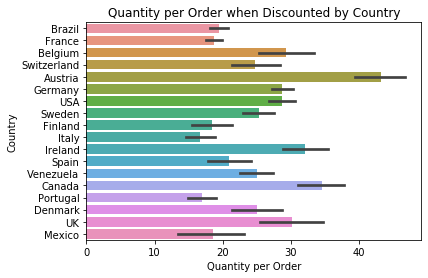

In [267]:
ax = sns.barplot(data=data ,x='data',y='group',ci=68)
ax.set(title= 'Quantity per Order when Discounted by Country', xlabel = 'Quantity per Order', ylabel='Country');

# Conclusion

The null hypothesis is rejected. Order quantities of different countries are not the same when discounted. It appears that Austria's order quantity is greater than 11 countries. Brazil is different from Canada, Germany, and USA. Canada is different from France and Italy and France is different from Germany, Ireland, and USA. 

It is recommended that Northwind evaluate which discounts it offers the countries with lower quantity orders and try to emulate the results seen in Austria.

# HYPOTHESIS 3

> ***Does purchase month have an effect on quantity per order?***

- $H_0$: Purchase month does not have an effect on quantity per an order.
- $H_1$: Purchase month does have an effect on quantity per an order.

## Determine if data is numerical or categorical

In [268]:
# Analyzing quantity per an order determines that the data is numerical.

In [269]:
cur.execute("""SELECT * FROM 'Order'""")
names = [description[0] for description in cur.description]
df_order = pd.DataFrame(cur.fetchall(), columns = names)
df_order.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [270]:
cur.execute("""SELECT * FROM OrderDetail """)
names = [description[0] for description in cur.description]
df_OrderDetail = pd.DataFrame(cur.fetchall(), columns = names)
df_OrderDetail

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.00,12,0.00
1,10248/42,10248,42,9.80,10,0.00
2,10248/72,10248,72,34.80,5,0.00
3,10249/14,10249,14,18.60,9,0.00
4,10249/51,10249,51,42.40,40,0.00
...,...,...,...,...,...,...
2150,11077/64,11077,64,33.25,2,0.03
2151,11077/66,11077,66,17.00,1,0.00
2152,11077/73,11077,73,15.00,2,0.01
2153,11077/75,11077,75,7.75,4,0.00


In [271]:
# Prepare df_order to merge with df_OrderDetail

df_order.rename({'Id':'OrderId'}, axis=1, inplace=True)
df_order.head()

,OrderId,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [272]:
df_merge = df_OrderDetail.merge(df_order, on='OrderId', copy=True)
df_merge.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248/11,10248,11,14.0,12,0.0,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10248/42,10248,42,9.8,10,0.0,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
2,10248/72,10248,72,34.8,5,0.0,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
3,10249/14,10249,14,18.6,9,0.0,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
4,10249/51,10249,51,42.4,40,0.0,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany


In [273]:
# Convert date to standardized format.

pd.to_datetime(df_merge['OrderDate'], format='%Y/%m/%d').head()

0   2012-07-04
1   2012-07-04
2   2012-07-04
3   2012-07-05
4   2012-07-05
Name: OrderDate, dtype: datetime64[ns]

In [274]:
df_merge['OrderMonth'] = pd.DatetimeIndex(df_merge['OrderDate']).month
df_merge['OrderYear'] = pd.DatetimeIndex(df_merge['OrderDate']).year
df_merge.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,CustomerId,EmployeeId,OrderDate,RequiredDate,...,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,OrderMonth,OrderYear
0,10248/11,10248,11,14.0,12,0.0,VINET,5,2012-07-04,2012-08-01,...,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,7,2012
1,10248/42,10248,42,9.8,10,0.0,VINET,5,2012-07-04,2012-08-01,...,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,7,2012
2,10248/72,10248,72,34.8,5,0.0,VINET,5,2012-07-04,2012-08-01,...,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,7,2012
3,10249/14,10249,14,18.6,9,0.0,TOMSP,6,2012-07-05,2012-08-16,...,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,7,2012
4,10249/51,10249,51,42.4,40,0.0,TOMSP,6,2012-07-05,2012-08-16,...,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,7,2012


## Determine how many groups to compare to establish which test to use.

### More than two groups are being compared; use the ANOVA test.

### Check data to see if it meets test assumptions.

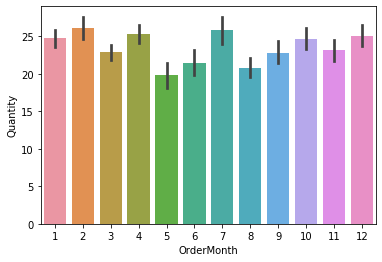

In [275]:
# View barplot to see if the categories are statistically different and compare standard error of the mean.

sns.barplot(data=df_merge, x='OrderMonth', y='Quantity', ci=68 )

In [276]:
# Create 'grps' dictionary to seperate 'quantity' into 'OrderMonth' categories.

grps = {}
for grp_name in df_merge['OrderMonth'].unique():
    grps[grp_name] = df_merge.groupby('OrderMonth').get_group(grp_name)['Quantity']
grps

{7: 0       12
 1       10
 2        5
 3        9
 4       40
 5       10
 6       35
 7       15
 8        6
 9       15
 10      20
 11      40
 12      25
 13      40
 14      20
 15      42
 16      40
 17      15
 18      21
 19      21
 20      20
 21      35
 22      25
 23      30
 24      15
 25      12
 26      25
 27       6
 28      15
 29      50
 30      65
 31       6
 32      10
 33       1
 34      16
 35      50
 36      15
 37      21
 38      20
 39      20
 40      12
 41      15
 42       2
 43      60
 44      28
 45      60
 46      36
 47      35
 48      25
 49      30
 50      20
 51      12
 52      50
 53      70
 54      15
 55      10
 56       4
 57      60
 58      20
 899     15
 900      4
 901      6
 902     20
 903     20
 904     40
 905    100
 906      4
 907     20
 908     60
 909     14
 910     10
 911     50
 912     25
 913      5
 914     21
 915     20
 916      4
 917     24
 918     30
 919     30
 920    120
 921     65
 922      5
 

### Check for outliers.

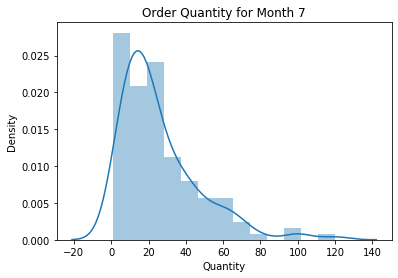

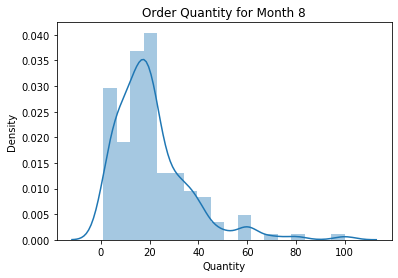

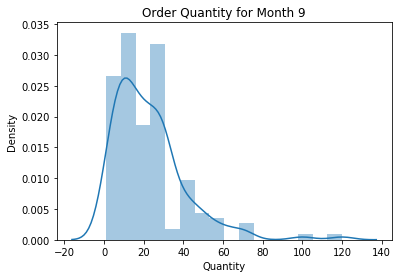

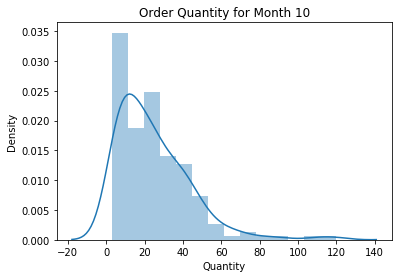

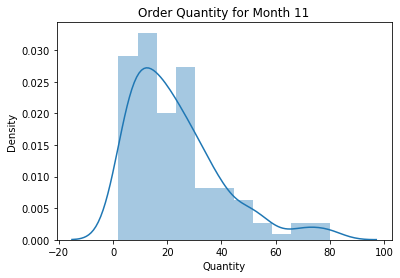

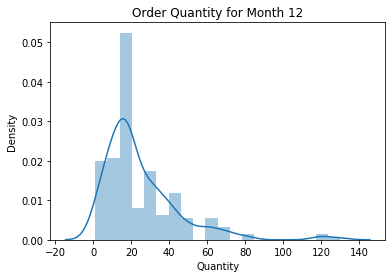

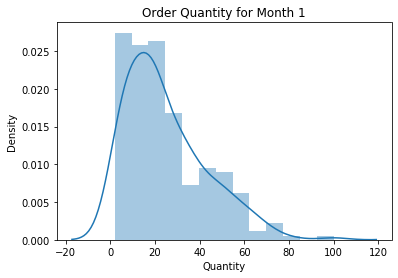

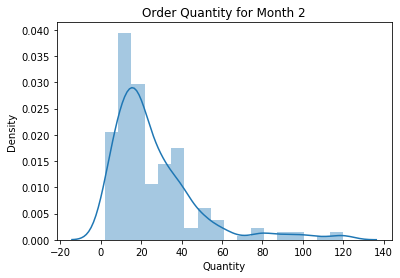

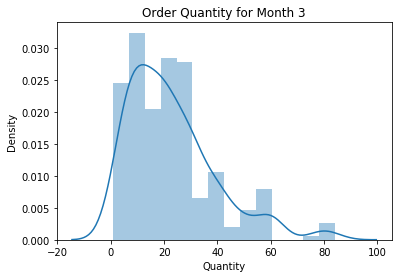

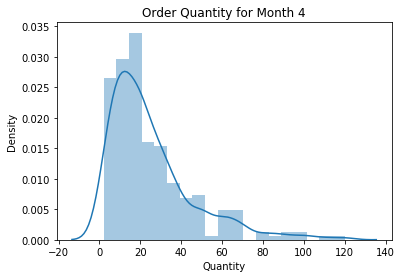

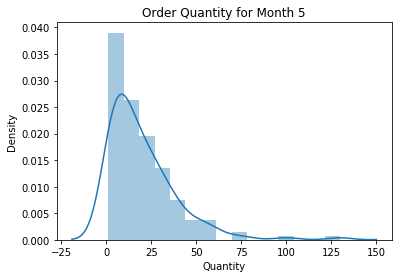

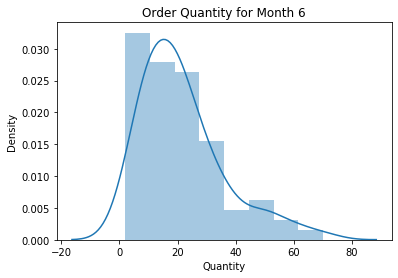

In [277]:
# Show distribution plot of 'month' groups to determine if normailty assumption is met.

for grp_name,grp_data in grps.items():
    fig,ax =plt.subplots()
    sns.distplot(grp_data,label=grp_name, ax=ax)
    ax.set(title=f'Order Quantity for Month {grp_name}', ylabel='Density')

In [278]:
orig_grps = grps.copy()

In [279]:
# Identify how many outliers found in each group using Z-Scores.

for grp_name, grp_data in grps.items():
    idx_outs = find_outliers_Z(grp_data)
    print(f"Found {idx_outs.sum()} outliers in {grp_name} using Z-scores")
    grps[grp_name] = grp_data [~idx_outs]

Found 3 outliers in 7 using Z-scores
Found 3 outliers in 8 using Z-scores
Found 2 outliers in 9 using Z-scores
Found 3 outliers in 10 using Z-scores
Found 3 outliers in 11 using Z-scores
Found 3 outliers in 12 using Z-scores
Found 2 outliers in 1 using Z-scores
Found 6 outliers in 2 using Z-scores
Found 5 outliers in 3 using Z-scores
Found 6 outliers in 4 using Z-scores
Found 2 outliers in 5 using Z-scores
Found 1 outliers in 6 using Z-scores


In [280]:
# Remove outliers.

grp_data[~idx_outs]

823    30
824    35
825    18
826    20
827    40
828    24
829    30
830    20
831    25
832    20
833    30
834    18
835     3
836    12
837    18
838    20
839    15
840    10
841    50
842    20
843    10
844    25
846    16
847     6
848    25
849    25
850    18
851    35
852    18
853    10
854    60
855     3
856    40
857     5
858    35
859    30
860    15
861    60
862    11
863    28
864    12
865    10
866    50
867    15
868    18
869    40
870    25
871    14
872     2
873    10
874     6
875    12
876     6
877    30
878    10
879    10
880    20
881    21
882    10
883    20
884    18
885    20
886     6
887    10
888    21
889    15
890     9
891    30
892    50
893     4
894    14
895    10
896    24
897    10
898    50
Name: Quantity, dtype: int64

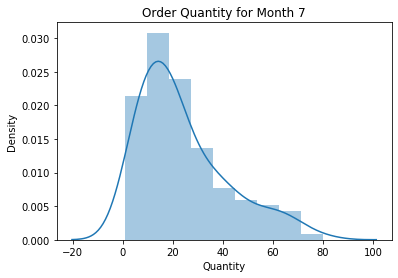

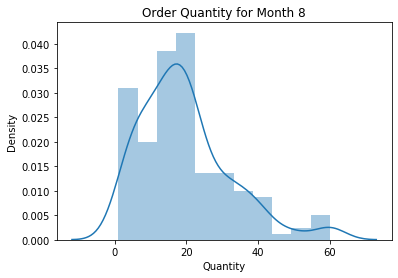

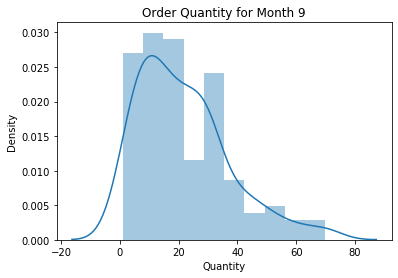

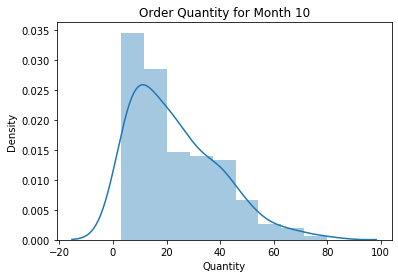

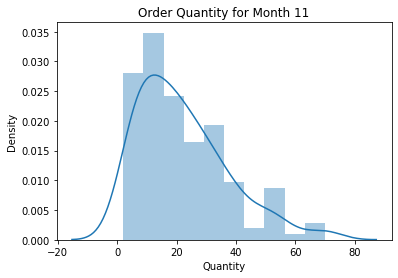

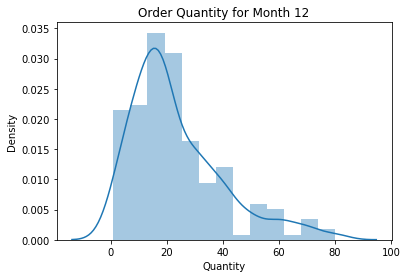

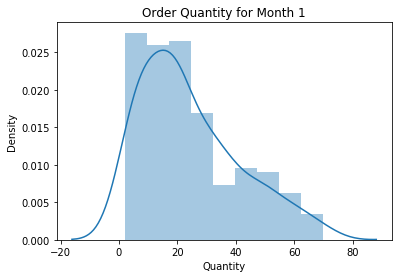

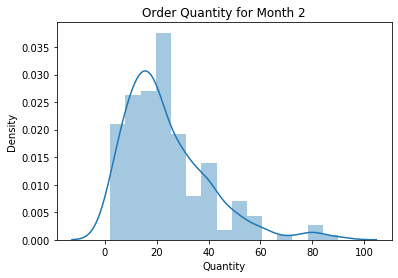

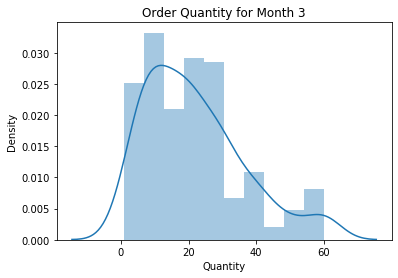

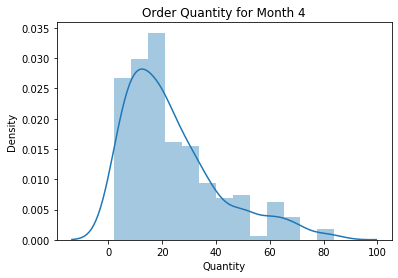

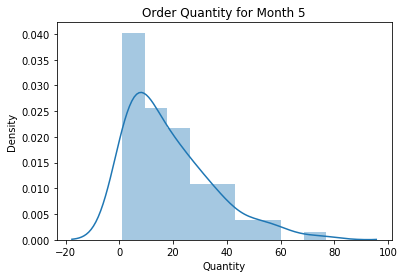

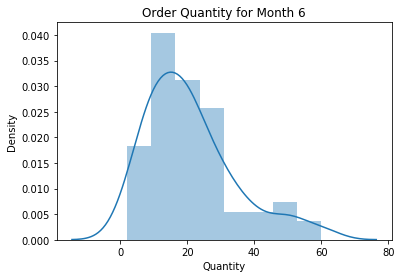

In [281]:
# Check for normality after removing outliers.

for grp_name,grp_data in grps.items():
    fig,ax =plt.subplots()
    sns.distplot(grp_data,label=grp_name, ax=ax)
    ax.set(title=f'Order Quantity for Month {grp_name}', ylabel='Density')

### Confirm normality with scipy normal test.

In [282]:
# Failed normality test; check sample sizes to see if large enough to bypass normality assumption.
# Each group is greater than 15; safe to ignore normality assumption.

In [283]:
for k,v in grps.items():
    stat,p = stats.normaltest(v)
    print(f"Group {k} Normaltest p-value = {round(p,4)}")
    sig = 'is NOT' if p<.05 else 'IS'
    print(f"\t-The data is {sig} normal.")
    print(f"Group {k} sample size = {len(v)}")
    size = 'CAN' if len(v)>20 else 'CAN NOT'
    print(f"\t-Normality assumption {size} be ignored.")
    print('\n')

Group 7 Normaltest p-value = 0.0
	-The data is is NOT normal.
Group 7 sample size = 133
	-Normality assumption CAN be ignored.


Group 8 Normaltest p-value = 0.0
	-The data is is NOT normal.
Group 8 sample size = 150
	-Normality assumption CAN be ignored.


Group 9 Normaltest p-value = 0.0
	-The data is is NOT normal.
Group 9 sample size = 150
	-Normality assumption CAN be ignored.


Group 10 Normaltest p-value = 0.0
	-The data is is NOT normal.
Group 10 sample size = 176
	-Normality assumption CAN be ignored.


Group 11 Normaltest p-value = 0.0
	-The data is is NOT normal.
Group 11 sample size = 152
	-Normality assumption CAN be ignored.


Group 12 Normaltest p-value = 0.0
	-The data is is NOT normal.
Group 12 sample size = 192
	-Normality assumption CAN be ignored.


Group 1 Normaltest p-value = 0.0
	-The data is is NOT normal.
Group 1 sample size = 235
	-Normality assumption CAN be ignored.


Group 2 Normaltest p-value = 0.0
	-The data is is NOT normal.
Group 2 sample size = 195
	-N

## Check for equal variance.

In [284]:
# Prepare data for Levene test to check for equal variance.

data = []
for k,v in grps.items():
    data.append(v)
data[0]

0      12
1      10
2       5
3       9
4      40
5      10
6      35
7      15
8       6
9      15
10     20
11     40
12     25
13     40
14     20
15     42
16     40
17     15
18     21
19     21
20     20
21     35
22     25
23     30
24     15
25     12
26     25
27      6
28     15
29     50
30     65
31      6
32     10
33      1
34     16
35     50
36     15
37     21
38     20
39     20
40     12
41     15
42      2
43     60
44     28
45     60
46     36
47     35
48     25
49     30
50     20
51     12
52     50
53     70
54     15
55     10
56      4
57     60
58     20
899    15
900     4
901     6
902    20
903    20
904    40
906     4
907    20
908    60
909    14
910    10
911    50
912    25
913     5
914    21
915    20
916     4
917    24
918    30
919    30
921    65
922     5
923    24
924    30
925    35
926    20
927    12
928    50
929     9
930    10
931     4
932    30
933    60
934    35
935     5
936    48
937    25
938     6
939    10
940    30
941    20


In [285]:
# Does pass Levene test, the null hypothesis that all input samples are from populations with equal variances is true. 

stat, p = stats.levene(*data)
print(f"Levene Test for Equal Variance p-value= {round(p,4)}")
sig = 'do NOT' if p<.05 else 'DO'

print(f"\t- The groups {sig} have equal variance.")

Levene Test for Equal Variance p-value= 0.0521
	- The groups DO have equal variance.


In [286]:
# Check One-Way ANOVA to test the null hypothesis that two or more groups have the same population mean.
# P-value is less than 0.05; reject null hypothesis that month does not have an effect on quantity per an order.

stat,p = stats.f_oneway(*data)
print(f"One-Way ANOVA p-value={round(p,4)}")

One-Way ANOVA p-value=0.0204


In [287]:
# Prepare data for Tukey function.

data = fn.prep_data_for_tukeys(grps)
data

,data,group
0,12.0,7
1,10.0,7
2,5.0,7
3,9.0,7
4,40.0,7
...,...,...
894,14.0,6
895,10.0,6
896,24.0,6
897,10.0,6


In [288]:
model = pairwise_tukeyhsd(data['data'],data['group'])
model.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1,10,-0.9216,0.9,-6.1436,4.3004,False
1,11,-2.1342,0.9,-7.5869,3.3184,False
1,12,-0.7,0.9,-5.7961,4.3961,False
1,2,-0.5795,0.9,-5.654,4.495,False
1,3,-2.464,0.8602,-7.2236,2.2956,False
1,4,-0.7412,0.9,-5.4782,3.9958,False
1,5,-5.5399,0.0417,-10.9817,-0.098,True
1,6,-3.3333,0.9,-10.2808,3.6141,False
1,7,-0.1699,0.9,-5.8542,5.5143,False
1,8,-4.6467,0.1904,-10.1213,0.828,False


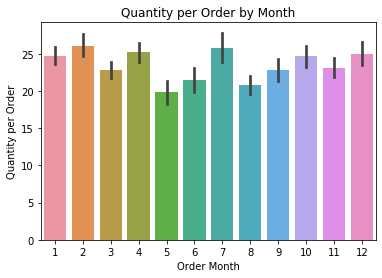

In [289]:
ax = sns.barplot(data=df_merge,x='OrderMonth',y='Quantity',ci=68)
ax.set(title= 'Quantity per Order by Month', xlabel = 'Order Month', ylabel='Quantity per Order');

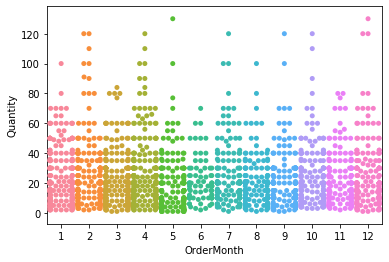

In [290]:
sns.swarmplot(data=df_merge,x='OrderMonth',y='Quantity')

# Conclusion

In conclusion, the null hypothesis is rejected, purchase month does have an effect on quantity per an order. While most months didn't appear to show a difference in quantity ordered, May stood out where order quantitites were lower than January. 

It is recommended that Northwind offer increased discount for May or other promotions.

# HYPOTHESIS 4

> ***Does region have an effect on quantity per order?***

- $H_0$: Region does not effect the quantity of a product in an order.
- $H_1$: Region does effect the quantity of a product in an order.

In [291]:
cur.execute("""SELECT * FROM 'Order'""")
names = [description[0] for description in cur.description]
df_order = pd.DataFrame(cur.fetchall(), columns = names)
df_order.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [292]:
cur.execute("""SELECT * FROM OrderDetail """)
names = [description[0] for description in cur.description]
df_OrderDetail = pd.DataFrame(cur.fetchall(), columns = names)
df_OrderDetail

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.00,12,0.00
1,10248/42,10248,42,9.80,10,0.00
2,10248/72,10248,72,34.80,5,0.00
3,10249/14,10249,14,18.60,9,0.00
4,10249/51,10249,51,42.40,40,0.00
...,...,...,...,...,...,...
2150,11077/64,11077,64,33.25,2,0.03
2151,11077/66,11077,66,17.00,1,0.00
2152,11077/73,11077,73,15.00,2,0.01
2153,11077/75,11077,75,7.75,4,0.00


In [293]:
# Prepare df_order to merge with df_OrderDetail
df_order.rename({'Id':'OrderId'}, axis=1, inplace=True)
df_order.head()

,OrderId,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [294]:
df_merge = df_OrderDetail.merge(df_order, on='OrderId', copy=True)
df_merge.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248/11,10248,11,14.0,12,0.0,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10248/42,10248,42,9.8,10,0.0,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
2,10248/72,10248,72,34.8,5,0.0,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
3,10249/14,10249,14,18.6,9,0.0,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
4,10249/51,10249,51,42.4,40,0.0,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany


In [295]:
cur.execute("""SELECT Id, Region FROM Customer """)
names = [description[0] for description in cur.description]
df_Customer = pd.DataFrame(cur.fetchall(), columns = names)
df_Customer

,Id,Region
0,ALFKI,Western Europe
1,ANATR,Central America
2,ANTON,Central America
3,AROUT,British Isles
4,BERGS,Northern Europe
5,BLAUS,Western Europe
6,BLONP,Western Europe
7,BOLID,Southern Europe
8,BONAP,Western Europe
9,BOTTM,North America


In [296]:
# Prepare df_Customer to merge with df_merge

df_Customer.rename({'Id':'CustomerId'}, axis=1, inplace=True)
df_Customer.head()

,CustomerId,Region
0,ALFKI,Western Europe
1,ANATR,Central America
2,ANTON,Central America
3,AROUT,British Isles
4,BERGS,Northern Europe


In [297]:
df_Region = df_merge.merge(df_Customer, on='CustomerId', copy=True)
df_Region.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Region
0,10248/11,10248,11,14.0,12,0.0,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,Western Europe
1,10248/42,10248,42,9.8,10,0.0,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,Western Europe
2,10248/72,10248,72,34.8,5,0.0,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,Western Europe
3,10274/71,10274,71,17.2,20,0.0,VINET,6,2012-08-06,2012-09-03,2012-08-16,1,6.01,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,Western Europe
4,10274/72,10274,72,27.8,7,0.0,VINET,6,2012-08-06,2012-09-03,2012-08-16,1,6.01,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,Western Europe


## Determine if data is numerical or categorical

In [298]:
# Data is numerical; comparing quantity per an order by region.

## Determine how many groups to compare to establish which test to use.

### More than two groups are being compared; use the ANOVA test.

### Check data to see if it meets test assumptions.

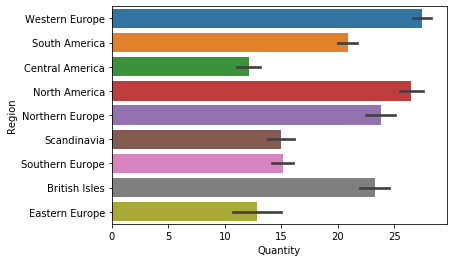

In [299]:
# View barplot to see if the categories are statistically different and compare standard error of the mean.

sns.barplot(data=df_Region, x='Quantity', y='Region', ci=68)

### Check for outliers.

In [300]:
# Create 'grps' dictionary to seperate 'regions' by 'quantity'.

grps = {}
for grp_name in df_Region['Region'].unique():
    grps[grp_name] = df_Region.groupby('Region').get_group(grp_name)['Quantity']
grps

{'Western Europe': 0        12
 1        10
 2         5
 3        20
 4         7
 5         4
 6         4
 7        12
 8         6
 9        18
 10        9
 11       40
 12       15
 13       20
 14       15
 15       12
 16       20
 17        3
 18       15
 19       10
 20       14
 21       28
 22       12
 23       40
 56        6
 57       15
 58       20
 59        8
 60       10
 61       20
 62        6
 63       16
 64       20
 65       40
 66       20
 67       10
 68       30
 69       40
 70       20
 71        2
 72       15
 73       20
 74       20
 75        8
 76       30
 77        4
 78       20
 79        4
 80       30
 81       40
 82       25
 83       40
 84       40
 85       28
 86       12
 87       30
 88       30
 89       20
 90       15
 91       50
 92       21
 93       50
 94       35
 95       60
 96       42
 97        2
 98       16
 99       30
 100      50
 101      15
 102      21
 103      30
 104      20
 105      20
 106      12
 107   

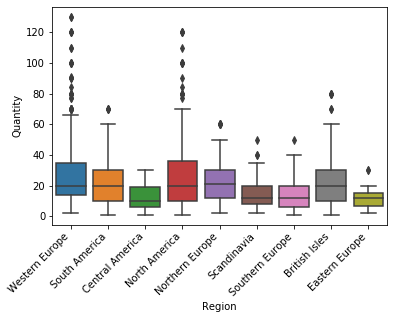

In [301]:
ax = sns.boxplot(data=df_Region, x='Region', y='Quantity')
current_labels = ax.get_xticklabels()
ax.set_xticklabels(current_labels, rotation=45, ha='right');

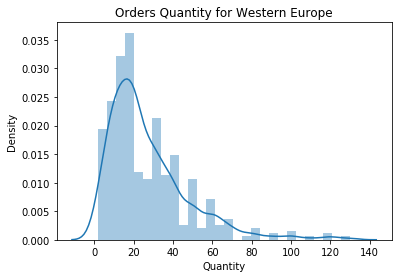

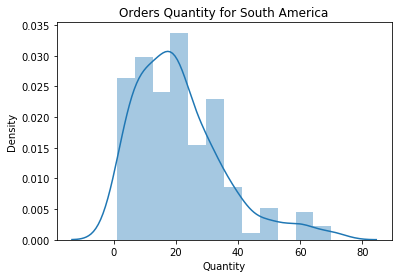

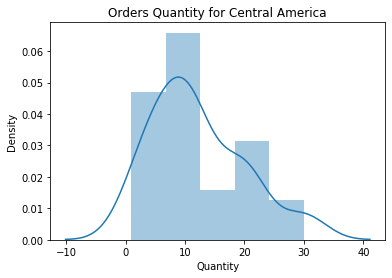

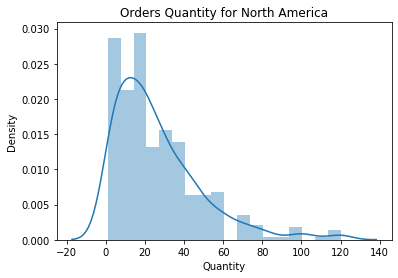

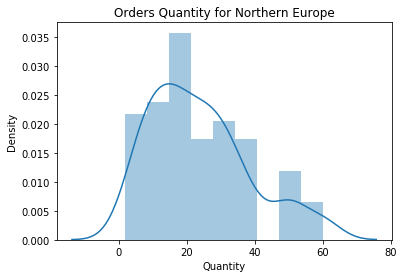

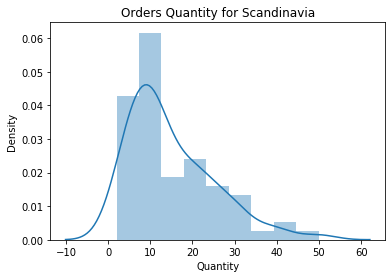

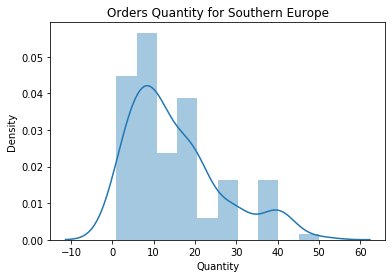

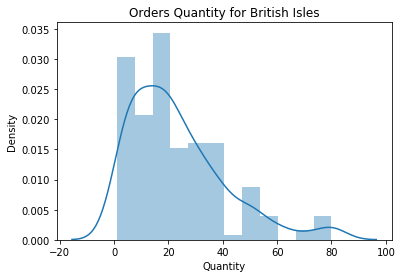

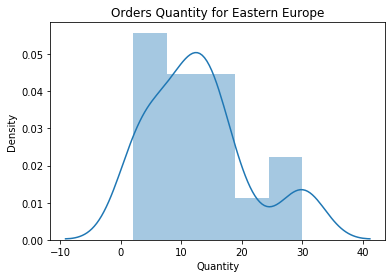

In [302]:
# Show distribution plots to determine if normailty assumption is met.

for grp_name,grp_data in grps.items():
    fig,ax =plt.subplots()
    sns.distplot(grp_data,label=grp_name, ax=ax)
    ax.set(title=f'Orders Quantity for {grp_name}', ylabel='Density')

In [303]:
orig_grps = grps.copy()

In [304]:
# Identify how many outliers found in each group using Z-Scores.

for grp_name, grp_data in orig_grps.items():
    idx_outs =find_outliers_IQR(grp_data)
    print(f"Found {idx_outs.sum()} outliers in {grp_name} using Z-scores")
    grps[grp_name] = grp_data [~idx_outs]
    idx_outs =find_outliers_IQR(grp_data)

Found 37 outliers in Western Europe using Z-scores
Found 4 outliers in South America using Z-scores
Found 0 outliers in Central America using Z-scores
Found 18 outliers in North America using Z-scores
Found 6 outliers in Northern Europe using Z-scores
Found 3 outliers in Scandinavia using Z-scores
Found 1 outliers in Southern Europe using Z-scores
Found 7 outliers in British Isles using Z-scores
Found 2 outliers in Eastern Europe using Z-scores


In [305]:
# Prepare data for analysis.

data = fn.prep_data_for_tukeys(grps)
data

,data,group
0,12.0,Western Europe
1,10.0,Western Europe
2,5.0,Western Europe
3,20.0,Western Europe
4,7.0,Western Europe
...,...,...
1754,15.0,Eastern Europe
1755,12.0,Eastern Europe
1756,7.0,Eastern Europe
1757,20.0,Eastern Europe


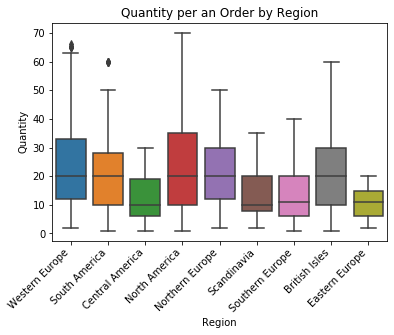

In [306]:
ax = sns.boxplot(data=data, x='group', y='data')
current_labels = ax.get_xticklabels()
ax.set_xticklabels(current_labels, rotation=45, ha='right')
ax.set(title='Quantity per an Order by Region', xlabel='Region',ylabel='Quantity');

### Confirm normality with scipy normal test.

In [307]:
for k,v in grps.items():
    stat,p = stats.normaltest(v)
    print(f"Group {k} Normaltest p-value = {round(p,4)}")
    sig = 'is NOT' if p<.05 else 'IS'
    print(f"\t-The data is {sig} normal.")
    print(f"Group {k} sample size = {len(v)}")
    size = 'CAN' if len(v)>20 else 'CAN NOT'
    print(f"\t-Normality assumption {size} be ignored.")
    print('\n');

Group Western Europe Normaltest p-value = 0.0
	-The data is is NOT normal.
Group Western Europe sample size = 699
	-Normality assumption CAN be ignored.


Group South America Normaltest p-value = 0.0
	-The data is is NOT normal.
Group South America sample size = 300
	-Normality assumption CAN be ignored.


Group Central America Normaltest p-value = 0.0733
	-The data is IS normal.
Group Central America sample size = 55
	-Normality assumption CAN be ignored.


Group North America Normaltest p-value = 0.0
	-The data is is NOT normal.
Group North America sample size = 409
	-Normality assumption CAN be ignored.


Group Northern Europe Normaltest p-value = 0.0171
	-The data is is NOT normal.
Group Northern Europe sample size = 137
	-Normality assumption CAN be ignored.


Group Scandinavia Normaltest p-value = 0.0485
	-The data is is NOT normal.
Group Scandinavia sample size = 67
	-Normality assumption CAN be ignored.


Group Southern Europe Normaltest p-value = 0.0001
	-The data is is NOT no

/Users/srn/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=14



In [308]:
# Failed normality test, however sample sizes are large enough to bypass normality assumption.

In [309]:
# Prepare data for  to check for equal variance.

data = []
for k,v in grps.items():
    data.append(v)
data[0]

0       12
1       10
2        5
3       20
4        7
5        4
6        4
7       12
8        6
9       18
10       9
11      40
12      15
13      20
14      15
15      12
16      20
17       3
18      15
19      10
20      14
21      28
22      12
23      40
56       6
57      15
58      20
59       8
60      10
61      20
62       6
63      16
64      20
65      40
66      20
67      10
68      30
69      40
70      20
71       2
72      15
73      20
74      20
75       8
76      30
77       4
78      20
79       4
80      30
81      40
82      25
83      40
84      40
85      28
86      12
87      30
88      30
89      20
90      15
91      50
92      21
93      50
94      35
95      60
96      42
97       2
98      16
99      30
100     50
101     15
102     21
103     30
104     20
105     20
106     12
107     30
108     25
109     36
110     25
111     25
112     30
113     10
114     60
115     30
116     10
117      5
118      2
119     30
120     15
121     21
122     21

In [310]:
# Reject the null hypothesis that all input samples are from populations with equal variances.

stats.levene(*data)

LeveneResult(statistic=10.50422597229473, pvalue=1.5815240871392774e-14)

In [311]:
# Reject the null hypothesis that the population median of all of the groups are equal.

stats.kruskal(*data)

KruskalResult(statistic=113.15890053376577, pvalue=8.529147016805946e-21)

In [312]:
# Prepare data for Tukey function.

data = fn.prep_data_for_tukeys(grps)
data

,data,group
0,12.0,Western Europe
1,10.0,Western Europe
2,5.0,Western Europe
3,20.0,Western Europe
4,7.0,Western Europe
...,...,...
1754,15.0,Eastern Europe
1755,12.0,Eastern Europe
1756,7.0,Eastern Europe
1757,20.0,Eastern Europe


In [313]:
model = pairwise_tukeyhsd(data['data'],data['group'])
model.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
British Isles,Central America,-9.1259,0.0014,-16.038,-2.2138,True
British Isles,Eastern Europe,-10.8778,0.1446,-23.3422,1.5865,False
British Isles,North America,2.1709,0.7273,-1.8267,6.1685,False
British Isles,Northern Europe,0.9913,0.9,-4.087,6.0696,False
British Isles,Scandinavia,-7.5633,0.008,-13.9818,-1.1448,True
British Isles,South America,-0.9716,0.9,-5.1878,3.2445,False
British Isles,Southern Europe,-6.36,0.0034,-11.4489,-1.271,True
British Isles,Western Europe,2.9596,0.2512,-0.7729,6.6921,False
Central America,Eastern Europe,-1.7519,0.9,-15.2076,11.7037,False
Central America,North America,11.2968,0.001,4.8411,17.7525,True


In [314]:
df = pd.DataFrame(data=model._results_table.data[1:], columns=model._results_table.data[0])
df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,British Isles,Central America,-9.1259,0.0014,-16.0380,-2.2138,True
1,British Isles,Eastern Europe,-10.8778,0.1446,-23.3422,1.5865,False
2,British Isles,North America,2.1709,0.7273,-1.8267,6.1685,False
3,British Isles,Northern Europe,0.9913,0.9000,-4.0870,6.0696,False
4,British Isles,Scandinavia,-7.5633,0.0080,-13.9818,-1.1448,True
5,British Isles,South America,-0.9716,0.9000,-5.1878,3.2445,False
6,British Isles,Southern Europe,-6.3600,0.0034,-11.4489,-1.2710,True
7,British Isles,Western Europe,2.9596,0.2512,-0.7729,6.6921,False
8,Central America,Eastern Europe,-1.7519,0.9000,-15.2076,11.7037,False
9,Central America,North America,11.2968,0.0010,4.8411,17.7525,True


In [315]:
df_grp12p = df[df['reject'] == True][['group1', 'group2','p-adj']]
df_grp12p.reset_index(drop=True, inplace= True)
df_grp12p

,group1,group2,p-adj
0,British Isles,Central America,0.0014
1,British Isles,Scandinavia,0.0080
2,British Isles,Southern Europe,0.0034
3,Central America,North America,0.0010
4,Central America,Northern Europe,0.0010
5,Central America,South America,0.0040
6,Central America,Western Europe,0.0010
7,Eastern Europe,North America,0.0260
8,Eastern Europe,Western Europe,0.0121
9,North America,Scandinavia,0.0010


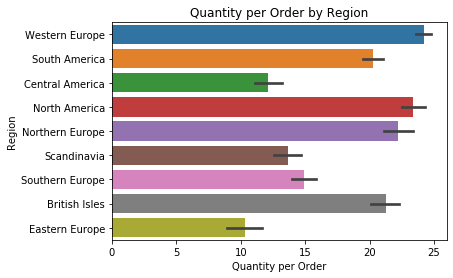

In [317]:
ax = sns.barplot(data=data ,x='data',y='group',ci=68)# order=bar)
ax.set(title= 'Quantity per Order by Region', xlabel = 'Quantity per Order', ylabel='Region');

# Conclusion

The null hypothesis is rejected, region does effect the quantity of a product in an order. 

It is recommended to focus marketing efforts in Central America, Scandinavia, and Eastern Europe to increase order quantity.

# Overall Conclusion

 When answering the proposed questions, the following recommendations are suggested:
 
 H1 Does discount amount have a statistically significant effect on order quantity? If so, at what level(s) of discount?

It is recommended to offer a 5% discount and not offer the other discounts in order to save revenue.

H2 Do order quantities of countries differ when discounted?

It is recommended that Northwind evaluate which discounts it offers the countries with lower quantity orders and try to emulate the results seen in Austria.

H3 Does purchase month have an effect on quantity per order?

It is recommended that Northwind offer increased discount for May or other promotions.

H4 Does region have an effect on quantity per order?

It is recommended to focus marketing efforts in Central America, Scandinavia, and Eastern Europe to increase order quantity.

It was concluded that all the answer were yes, all of the variables did to some extent have an effect on overall sales. It is recommended to focus marketing efforts where lower performance was observed.